In [1]:
import pandas as pd
import numpy as np
from bcb import sgs
from bcb import currency
from bcb import Expectativas
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

#### Buscando SELIC

In [69]:
selic = sgs.get({'selic' : 432}, start = '2023-01-01')

In [70]:
selic = selic.reset_index()

In [71]:
selic.tail(6)

,Date,selic
63,2023-03-05,13.75
64,2023-03-06,13.75
65,2023-03-07,13.75
66,2023-03-08,13.75
67,2023-03-09,13.75
68,2023-03-10,13.75


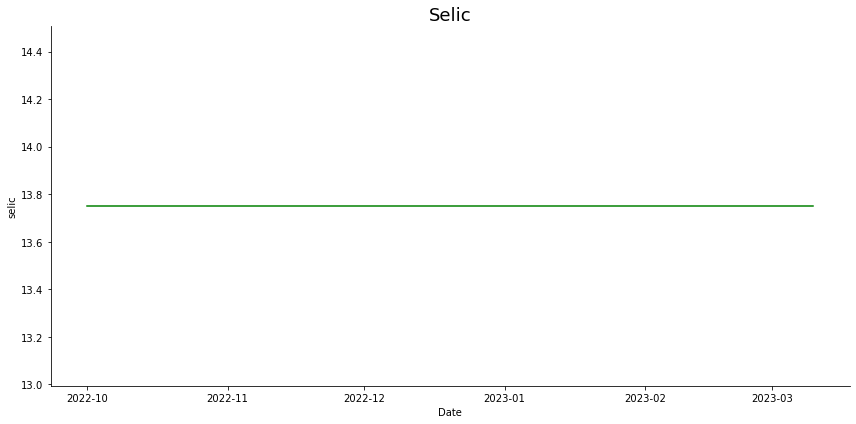

In [67]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(data = selic, x = 'Date', y = 'selic', color = 'green')
ax.set_title('Selic', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show();

In [72]:
tjlp = sgs.get({'tjlp' : 256}, start = '2023-01-01')

In [73]:
tjlp = tjlp.reset_index()

In [74]:
tjlp.tail(6)

,Date,tjlp
0,2023-01-01,7.37
1,2023-02-01,7.37
2,2023-03-01,7.37


#### Inflacao

In [56]:
inflacao = sgs.get({'ipca' : 433, 'igp-m' : 189, 'inpc' : 188}, start = '2010-01-01')

In [57]:
inflacao = inflacao.reset_index()

In [58]:
inflacao.tail(13)

,Date,ipca,igp-m,inpc
145,2022-02-01,1.01,1.83,1.00
146,2022-03-01,1.62,1.74,1.71
147,2022-04-01,1.06,1.41,1.04
148,2022-05-01,0.47,0.52,0.45
149,2022-06-01,0.67,0.59,0.62
150,2022-07-01,-0.68,0.21,-0.60
151,2022-08-01,-0.36,-0.70,-0.31
152,2022-09-01,-0.29,-0.95,-0.32
153,2022-10-01,0.59,-0.97,0.47
154,2022-11-01,0.41,-0.56,0.38


In [59]:
def inflacao_ipca_anual(df_inflacao):
    inflacao_df = df_inflacao.copy()
    inflacao_df = inflacao_df.reset_index()
    inflacao_df = inflacao_df.tail(13)
    
    # acumulando IPCA
    inflacao_ipca = inflacao_df[['Date', 'ipca']].dropna()
    inflacao_ipca = inflacao_ipca.assign(ipca_indice = False)
    for i in inflacao_ipca.loc[1:, 'ipca_indice']:
        inflacao_ipca['ipca_indice'] = (inflacao_ipca['ipca'] / 100) + 1
    
    inflacao_ipca.iloc[0, -1] = 1
    inflacao_ipca['ipca_acumulado'] = np.cumprod(inflacao_ipca['ipca_indice'])
    
    inflacao_12meses_ipca = inflacao_ipca['ipca_acumulado'].tail(1).item()
    inflacao_12meses_ipca = round((inflacao_12meses_ipca - 1) * 100, 2)
    
    # acumulando IGP-M
    inflacao_igpm = inflacao_df[['Date', 'igp-m']].dropna()
    inflacao_igpm = inflacao_igpm.assign(igpm_indice = False)
    for i in inflacao_igpm.loc[1:, 'igpm_indice']:
        inflacao_igpm['igpm_indice'] = (inflacao_igpm['igp-m'] / 100) + 1
    
    inflacao_igpm.iloc[0, -1] = 1
    inflacao_igpm['igpm_acumulado'] = np.cumprod(inflacao_igpm['igpm_indice'])
    
    inflacao_12meses_igpm = inflacao_igpm['igpm_acumulado'].tail(1).item()
    inflacao_12meses_igpm = round((inflacao_12meses_igpm - 1) * 100, 2)
    
    # acumulando inpc
    inflacao_inpc = inflacao_df[['Date', 'inpc']].dropna()
    inflacao_inpc = inflacao_inpc.assign(inpc_indice = False)
    for i in inflacao_inpc.loc[1:, 'inpc_indice']:
        inflacao_inpc['inpc_indice'] = (inflacao_inpc['inpc'] / 100) + 1
    
    inflacao_inpc.iloc[0, -1] = 1
    inflacao_inpc['inpc_acumulado'] = np.cumprod(inflacao_inpc['inpc_indice'])
    
    inflacao_12meses_inpc = inflacao_inpc['inpc_acumulado'].tail(1).item()
    inflacao_12meses_inpc = round((inflacao_12meses_inpc - 1) * 100, 2)
    
    
    return inflacao_12meses_ipca, inflacao_12meses_igpm, inflacao_12meses_inpc

In [63]:
inflacao_ipca_anual(inflacao)

(5.6, 1.86, 4.66)

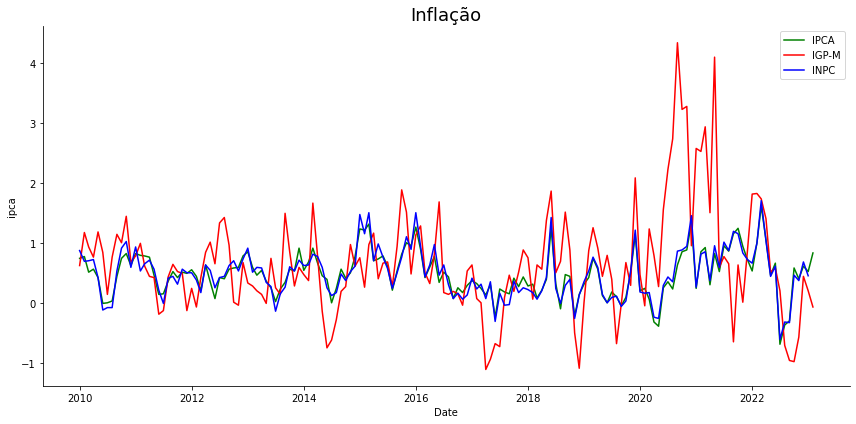

In [25]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(data = inflacao, x = 'Date', y = 'ipca', color = 'green', label = 'IPCA')
sns.lineplot(data = inflacao, x = 'Date', y = 'igp-m', color = 'red', label = 'IGP-M')
sns.lineplot(data = inflacao, x = 'Date', y = 'inpc', color = 'blue', label = 'INPC')
ax.set_title('Inflação', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show();

#### PIB

In [2]:
pib = sgs.get({'ibcbr' : 24363}, start = '2022-01-01')

In [3]:
pib = pib.reset_index()

In [4]:
pib.tail(6)

,Date,ibcbr
6,2022-07-01,149.41
7,2022-08-01,149.46
8,2022-09-01,144.64
9,2022-10-01,142.79
10,2022-11-01,141.55
11,2022-12-01,143.62


#### Taxa de Desocupação (Desemprego) - PNADC

In [13]:
desemprego = sgs.get({'desoc_pnadc' : 24369}, start = '2022-01-01')

In [14]:
desemprego = desemprego.reset_index()

In [15]:
desemprego.tail(6)

,Date,desoc_pnadc
5,2022-06-01,9.3
6,2022-07-01,9.1
7,2022-08-01,8.9
8,2022-09-01,8.7
9,2022-10-01,8.3
10,2022-11-01,8.1


#### Moedas

In [157]:
# Um dia na frente por causa do python fazendo o range + 1
hoje = datetime.date.today()
inicio = hoje - datetime.timedelta(days = 7)
fim = hoje + datetime.timedelta(days = 1)
moedas_busca = 'USDBRL=X EURBRL=X GBPBRL=X'

In [172]:
# Pelo yfinance é mais recente
def obtendo_cambio(moedas, data_inicio, data_final):
    df = yf.download(moedas, start = data_inicio, end = data_final, progress = False)
    df = df[['Adj Close']].reset_index()
    df.columns = df.columns.droplevel(0)
    df = df.rename(columns = {'' :'Data'})
    dolar = round(df['USDBRL=X'].tail(1).item(), 2)
    euro = round(df['EURBRL=X'].tail(1).item(), 2)
    libra = round(df['GBPBRL=X'].tail(1).item(), 2)
    return dolar, euro, libra

In [173]:
obtendo_cambio(moedas_busca, inicio, fim)[0]

5.15

In [100]:
df_moedas = currency.get_currency_list()
df_moedas.head(4)

,code,name,symbol,country_code,country_name,type,exclusion_date
0,5,AFEGANE AFEGANIST,AFN,132,AFEGANISTAO ...,A,NaT
1,785,RANDE/AFRICA SUL,ZAR,7560,AFRICA DO SUL ...,A,NaT
2,490,LEK ALBANIA REP,ALL,175,"ALBANIA, REPUBLICA DA ...",A,NaT
3,610,MARCO ALEMAO,DEM,230,ALEMANHA ...,A,2002-01-02


In [112]:
hoje = datetime.date.today() + datetime.timedelta(days = 1)
hoje

datetime.date(2022, 11, 9)

In [ ]:
hoje = hoje + datetime.timedelta(days = 1)
hoje

In [126]:
moedas = currency.get(['USD', 'EUR', 'GBP'], start = '2022-01-01', end = '2022-11-09')

In [127]:
moedas = moedas.reset_index()

In [128]:
moedas

,Date,EUR,GBP,USD
0,2022-01-03,6.3595,7.5724,5.6309
1,2022-01-04,6.4219,7.6954,5.6776
2,2022-01-05,6.4210,7.6816,5.6628
3,2022-01-06,6.4435,7.7178,5.7042
4,2022-01-07,6.4415,7.7037,5.6753
...,...,...,...,...
208,2022-10-31,5.1976,6.0534,5.2570
209,2022-11-01,5.0851,5.9029,5.1500
210,2022-11-03,5.0122,5.7434,5.1349
211,2022-11-04,4.9841,5.6801,5.0360


In [116]:
round(moedas['USD'].tail(1), 2).item()

5.09

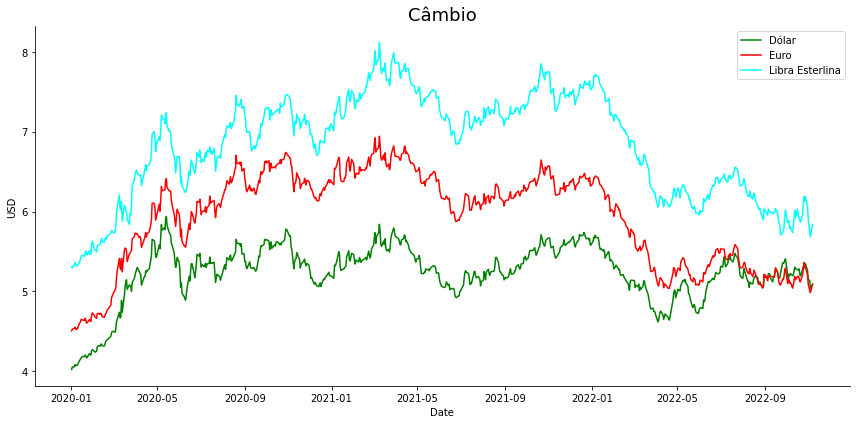

In [117]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(data = moedas, x = 'Date', y = 'USD', color = 'green', label = 'Dólar')
sns.lineplot(data = moedas, x = 'Date', y = 'EUR', color = 'red', label = 'Euro')
sns.lineplot(data = moedas, x = 'Date', y = 'GBP', color = 'cyan', label = 'Libra Esterlina')
ax.set_title('Câmbio', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show();

#### Expectativas

Expec Describe
EntitySets:
  - ExpectativasMercadoTop5Anuais
  - ExpectativasMercadoSelic
  - ExpectativasMercadoTop5Selic
  - ExpectativasMercadoTrimestrais
  - ExpectativasMercadoAnuais

ExpectativasMercadoTrimestrais:
- PIB Total
- PIB Agropecuária
- PIB Indústria
- PIB Serviços
- Taxa de desocupação
- IPCA
- Câmbio

ExpectativasMercadoTop5Mensais

In [24]:
expec = Expectativas()
#expec.describe()

# Utilizarei
# ExpectativasMercadoTrimestrais
# ExpectativasMercadoAnuais
# ExpectativasMercadoTop5Anuais TALVEZ

In [25]:
expec.describe()

EntitySets:
  ExpectativasMercadoTop5Anuais
  ExpectativaMercadoMensais
  ExpectativasMercadoInflacao12Meses
  ExpectativasMercadoSelic
  ExpectativasMercadoTop5Selic
  ExpectativasMercadoTop5Mensais
  ExpectativasMercadoTrimestrais
  ExpectativasMercadoAnuais


In [13]:
ep = expec.get_endpoint('ExpectativasMercadoAnuais')
df = ep.query().filter(
                       ep.Data > '2022-08-01',
                       ep.numeroRespondentes >= 20).select(ep.Data, ep.DataReferencia,
                                                           ep.Media, ep.Mediana, ep.Indicador).collect()

In [26]:
df.Indicador.value_counts()

IPCA                                               1516
Selic                                              1510
Câmbio                                             1466
PIB Total                                          1424
IGP-M                                              1251
IPCA Administrados                                 1203
IPCA Livres                                        1178
IPCA Serviços                                      1151
IPCA Alimentação no domicílio                      1142
IPCA Bens industrializados                         1136
Taxa de desocupação                                1084
Balança comercial                                   869
Dívida bruta do governo geral                       737
Resultado primário                                  602
PIB Agropecuária                                    574
PIB Serviços                                        530
PIB Indústria                                       529
Conta corrente                                  

##### Funcoes auxiliares

In [27]:
def obtendo_expectativas(indicador, entidade, respondentes):
    
    # Filtrando para previsoes dos ultimos 3 meses
    tres_meses = datetime.date.today() - datetime.timedelta(days = 90)
    tres_meses = tres_meses.strftime('%Y-%m-%d')
    
    # Obtendo dados
    ep = expec.get_endpoint(entidade)
    df_ep = ep.query().filter(ep.Indicador == indicador,
                              ep.Data >= tres_meses,
                              ep.numeroRespondentes >= respondentes).select(ep.Data, ep.DataReferencia,
                                                           ep.Media, ep.Mediana).collect()

    return df_ep

In [28]:
def unindo_prev(x):
    
    # Selecionando trimestres
    trimestres = ['1/2023', '2/2023', '3/2023', '4/2023', '1/2024', '2/2024']
    
    # Calculando as metricas
    dicio_metricas = {}
    df_aux = x.copy()
    for trimestre in trimestres:
        df_aux = x[(x['DataReferencia'] == trimestre)]
        dicio_metricas['media_{}'.format(trimestre)] = df_aux['Media'].mean()
        dicio_metricas['mediana_{}'.format(trimestre)] = df_aux['Mediana'].mean()
    
    # Colocando em um dataframe
    df = pd.DataFrame(list(dicio_metricas.items()))
    df.columns = ['metrica_trimestre', 'valor']
    df[['metrica', 'trimestres']] = df['metrica_trimestre'].str.split('_', n = 1, expand = True)
    df = df.drop(columns = 'metrica_trimestre')
    df = df[['trimestres', 'metrica', 'valor']]
    df['metrica'] = np.where(df['metrica'] == 'media', 'Média', 'Mediana')
    
    return df

### Obtendo Expectativas do PIB

#### Trimestrais

In [17]:
pib_total = obtendo_expectativas('PIB Total', 'ExpectativasMercadoTrimestrais', 50)
df_previsoes_pib = unindo_prev(pib_total)

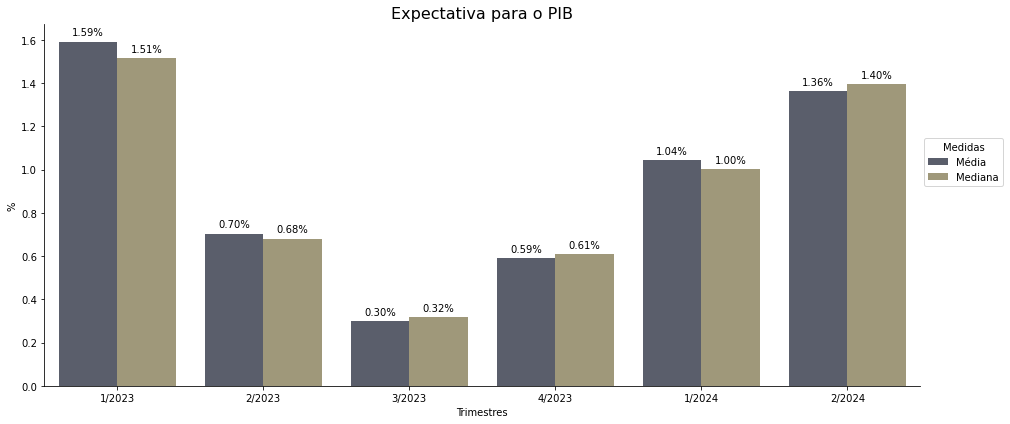

In [18]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(data = df_previsoes_pib, x = 'trimestres', y = 'valor', hue = 'metrica', palette = 'cividis')
ax.set_title('Expectativa para o PIB', fontsize = 16)
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel('Trimestres')
ax.set_ylabel('%')
ax.legend(title = 'Medidas', handles = handles, bbox_to_anchor = [1.1, 0.7, 0, 0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f%%', padding = 4)

fig.tight_layout()
plt.show();

#### Anual

In [147]:
pib_total = obtendo_expectativas('PIB Total', 'ExpectativasMercadoAnuais', 50)

In [151]:
pib_total[pib_total['DataReferencia'] == '2022']['Media'].mean()

2.49543625

#### Setores - Agropecuária, Industria e Serviços

In [29]:
pib_servicos = obtendo_expectativas('PIB Agropecuária', 'ExpectativasMercadoAnuais', 10)

In [30]:
pib_servicos[pib_servicos['DataReferencia'] == '2022']['Media'].mean()

-0.6543108695652172

In [31]:
pib_servicos['DataReferencia'].value_counts()

2023    102
2022     92
2024     85
2025     75
2026     74
Name: DataReferencia, dtype: int64

### Obtendo dados de expectativa para o IPCA

In [4]:
ep = expec.get_endpoint('ExpectativasMercadoTrimestrais')
df = ep.query().filter(ep.Data > '2022-08-01', ep.numeroRespondentes >= 30).select().collect()

In [335]:
df.Indicador.value_counts()

IPCA Administrados               475
IPCA Livres                      457
IPCA Serviços                    451
IPCA Bens industrializados       450
IPCA Alimentação no domicílio    450
Name: Indicador, dtype: int64

In [22]:
def obtendo_expectativas_varios(entidade, respondentes):
    
    # Filtrando para previsoes dos ultimos 3 meses
    tres_meses = datetime.date.today() - datetime.timedelta(days = 90)
    tres_meses = tres_meses.strftime('%Y-%m-%d')
    
    # Obtendo dados
    ep = expec.get_endpoint(entidade)
    df_ep = ep.query().filter(ep.Data >= tres_meses,
                              ep.numeroRespondentes >= respondentes).select().collect()

    return df_ep

In [29]:
def ipca_grupos_func(x):
    
    indicadores = ['IPCA Administrados', 'IPCA Livres', 'IPCA Alimentação no domicílio',
                   'IPCA Serviços', 'IPCA Bens industrializados']

    trimestres = ['4/2022', '1/2023', '2/2023', '3/2023', '4/2023']
    
    x = x[x['Indicador'].isin(indicadores)]
    x = x[x['DataReferencia'].isin(trimestres)]
    x_media = x.groupby(['Indicador', 'DataReferencia'], as_index = False)['Media'].mean()
    x_media['Indicador'] = np.where(x_media['Indicador'] == 'IPCA Bens industrializados', 'IPCA Bens Industrializados',
                                   np.where(x_media['Indicador'] == 'IPCA Alimentação no domicílio','IPCA Alimentação: Domicílio',
                                           x_media['Indicador']))
    return x_media

In [30]:
entidade_trimestrais = 'ExpectativasMercadoTrimestrais'
ipca_grupos = obtendo_expectativas_varios(entidade_trimestrais, 30)
df_ipca_grupos = ipca_grupos_func(ipca_grupos)

In [ ]:
def inflacao_junto(x):
    
    ep = expec.get_endpoint('ExpectativasMercadoTrimestrais')
    df = ep.query().filter(ep.Data > '2022-08-01', ep.numeroRespondentes >= 30).select().collect()
    
    # Calculando as metricas
    dicio_metricas = {}
    df_aux = x.copy()
    for trimestre in trimestres:
        df_aux = x[(x['DataReferencia'] == trimestre)]
        dicio_metricas['media_{}'.format(trimestre)] = df_aux['Media'].mean()
        dicio_metricas['mediana_{}'.format(trimestre)] = df_aux['Mediana'].mean()
    
    # Colocando em um dataframe
    df = pd.DataFrame(list(dicio_metricas.items()))
    df.columns = ['metrica_trimestre', 'valor']
    df[['metrica', 'trimestres']] = df['metrica_trimestre'].str.split('_', n = 1, expand = True)
    df = df.drop(columns = 'metrica_trimestre')
    df = df[['trimestres', 'metrica', 'valor']]
    df['metrica'] = np.where(df['metrica'] == 'media', 'Média', 'Mediana')
    
    return df

In [4]:
def obtendo_expectativas_varios(entidade, respondentes):
    
    # Filtrando para previsoes dos ultimos 3 meses
    tres_meses = datetime.date.today() - datetime.timedelta(days = 90)
    tres_meses = tres_meses.strftime('%Y-%m-%d')
    
    # Obtendo dados
    ep = expec.get_endpoint(entidade)
    df_ep = ep.query().filter(ep.Data >= tres_meses,
                              ep.numeroRespondentes >= respondentes).select().collect()

    return df_ep

In [56]:
def ipca_gp_ano_func(x):
    
    indicadores = ['IPCA Administrados', 'IPCA Livres', 'IPCA Alimentação no domicílio',
                   'IPCA Serviços', 'IPCA Bens industrializados']
    
    anos = ['2022', '2023']

    x = x[x['Indicador'].isin(indicadores)]
    x = x[x['DataReferencia'].isin(anos)]
    x_media = x.groupby(['Indicador', 'DataReferencia'], as_index = False)['Media'].mean()
    x_media['Indicador'] = np.where(x_media['Indicador'] == 'IPCA Bens industrializados', 'IPCA Bens Industrializados',
                                   np.where(x_media['Indicador'] == 'IPCA Alimentação no domicílio','IPCA Alimentação: Domicílio',
                                           x_media['Indicador']))
    return x_media

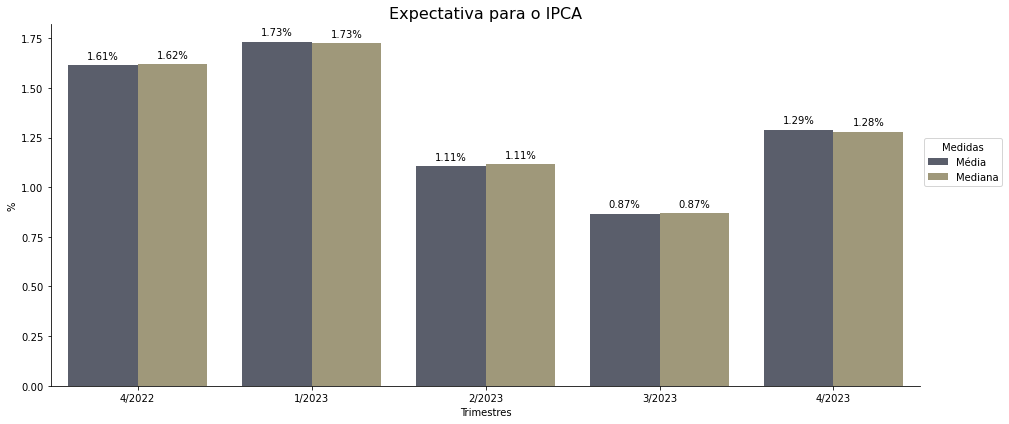

In [208]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(data = df_previsoes_ipca, x = 'trimestres', y = 'valor', hue = 'metrica', palette = 'cividis')
ax.set_title('Expectativa para o IPCA', fontsize = 16)
handles, labels = ax.get_legend_handles_labels()
labels = ['Média', 'Mediana']
ax.set_xlabel('Trimestres')
ax.set_ylabel('%')
ax.legend(title = 'Medidas', handles = handles, labels = labels, bbox_to_anchor = [1.1, 0.7, 0, 0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f%%', padding = 4)

fig.tight_layout()
plt.show();

### Obtendo expectativas para os Juros

In [4]:
def obtendo_expectativas(indicador, entidade, respondentes):
    
    # Filtrando para previsoes dos ultimos 3 meses
    tres_meses = datetime.date.today() - datetime.timedelta(days = 90)
    tres_meses = tres_meses.strftime('%Y-%m-%d')
    
    # Obtendo dados
    ep = expec.get_endpoint(entidade)
    df_ep = ep.query().filter(ep.Indicador == indicador,
                              ep.Data >= tres_meses,
                              ep.numeroRespondentes >= respondentes).select(ep.Data, ep.DataReferencia,
                                                           ep.Media, ep.Mediana, ep.Minimo, ep.Maximo,
                                                           ep.Indicador, ep.IndicadorDetalhe).collect()

    return df_ep

In [142]:
# ExpectativasMercadoAnuais tem SELIC
entidade = 'ExpectativasMercadoAnuais'
df = obtendo_expectativas('Taxa de desocupação', entidade, 30)

In [143]:
df

,Data,DataReferencia,Media,Mediana,Minimo,Maximo
0,2022-08-12,2022,8.9550,9.000,6.20,10.70
1,2022-08-12,2023,9.4392,9.590,7.00,11.60
2,2022-08-12,2024,9.2886,9.500,7.00,11.50
3,2022-08-12,2025,8.9268,9.000,6.50,11.00
4,2022-08-12,2026,8.7249,9.000,6.00,11.00
...,...,...,...,...,...,...
329,2022-11-04,2022,8.4365,8.400,7.50,9.10
330,2022-11-04,2023,8.9988,8.920,7.60,11.23
331,2022-11-04,2024,8.9451,8.900,7.50,11.50
332,2022-11-04,2025,8.7025,8.600,7.41,10.50


In [144]:
def unindo_selic(x):
    
    # Selecionando trimestres
    anos = ['2022', '2023']
    
    x = x[x['DataReferencia'].isin(anos)]
    
    # Calculando as metricas
    dicio_metricas = {}
    df_aux = x.copy()
    for ano in df_aux['DataReferencia']:
        dicio_metricas['media_{}'.format(ano)] = df_aux['Media'].mean()
        dicio_metricas['mediana_{}'.format(ano)] = df_aux['Mediana'].mean()
        dicio_metricas['maximo_{}'.format(ano)] = df_aux['Maximo'].mean()
        dicio_metricas['minimo_{}'.format(ano)] = df_aux['Minimo'].mean()
    
    # Colocando em um dataframe
    df = pd.DataFrame(list(dicio_metricas.items()))
    df.columns = ['metrica_trimestre', 'valor']
    df[['metrica', 'anos']] = df['metrica_trimestre'].str.split('_', n = 1, expand = True)
    df = df.drop(columns = 'metrica_trimestre')
    df = df[['anos', 'metrica', 'valor']]
    
    df['metrica'] = np.where(df['metrica'] == 'maximo', 'Máximo',
                              np.where(df['metrica'] == 'media', 'Média',
                                       np.where(df['metrica'] == 'minimo', 'Mínimo', 'Mediana')))
    
    return df

In [145]:
unindo_selic(df)

,anos,metrica,valor
0,2022,Média,8.914928
1,2022,Mediana,8.961242
2,2022,Máximo,10.815489
3,2022,Mínimo,7.027517
4,2023,Média,8.914928
5,2023,Mediana,8.961242
6,2023,Máximo,10.815489
7,2023,Mínimo,7.027517


#### Trimestral

In [168]:
entidade = 'ExpectativasMercadoTrimestrais'
df = obtendo_expectativas('Taxa de desocupação', entidade, 30)

In [169]:
df

,Data,DataReferencia,Media,Mediana,Minimo,Maximo
0,2022-08-12,3/2022,9.1017,9.1000,7.7,10.10
1,2022-08-12,4/2022,8.9485,9.0000,6.2,10.70
2,2022-08-12,1/2023,9.8013,9.8781,7.1,11.67
3,2022-08-12,2/2023,9.7386,9.9000,7.3,11.76
4,2022-08-12,3/2023,9.6337,9.8950,5.7,11.72
...,...,...,...,...,...,...
420,2022-11-04,4/2022,8.4261,8.4000,7.5,9.10
421,2022-11-04,1/2023,9.2302,9.1000,7.5,11.67
422,2022-11-04,2/2023,9.1343,9.0000,7.7,11.76
423,2022-11-04,3/2023,9.0991,9.0000,7.7,11.72


In [170]:
def unindo_prev(x):
    
    # Selecionando trimestres
    trimestres = ['4/2022', '1/2023', '2/2023', '3/2023', '4/2023']
    
    # Calculando as metricas
    dicio_metricas = {}
    df_aux = x.copy()
    for trimestre in trimestres:
        df_aux = x[(x['DataReferencia'] == trimestre)]
        dicio_metricas['media_{}'.format(trimestre)] = df_aux['Media'].mean()
        dicio_metricas['mediana_{}'.format(trimestre)] = df_aux['Mediana'].mean()
    
    # Colocando em um dataframe
    df = pd.DataFrame(list(dicio_metricas.items()))
    df.columns = ['metrica_trimestre', 'valor']
    df[['metrica', 'trimestres']] = df['metrica_trimestre'].str.split('_', n = 1, expand = True)
    df = df.drop(columns = 'metrica_trimestre')
    df = df[['trimestres', 'metrica', 'valor']]
    df['metrica'] = np.where(df['metrica'] == 'media', 'Média', 'Mediana')
    
    return df

In [171]:
unindo_prev(df)

,trimestres,metrica,valor
0,4/2022,Média,8.613451
1,4/2022,Mediana,8.639792
2,1/2023,Média,9.407821
3,1/2023,Mediana,9.407993
4,2/2023,Média,9.370833
5,2/2023,Mediana,9.391372
6,3/2023,Média,9.325289
7,3/2023,Mediana,9.413403
8,4/2023,Média,9.184332
9,4/2023,Mediana,9.312500


#### Obtendo expectativas para o cambio: Taxa de Desocupação

In [11]:
previsao_desocupacao = obtendo_expectativas('Taxa de desocupação')
df_previsoes_desocupacao = unindo_prev(previsao_desocupacao)

C:\Users\thari\AppData\Local\Temp\ipykernel_1204\3837323876.py:21: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['metrica', 'trimestres']] = df['metrica_trimestre'].str.split('_', 1, expand = True)


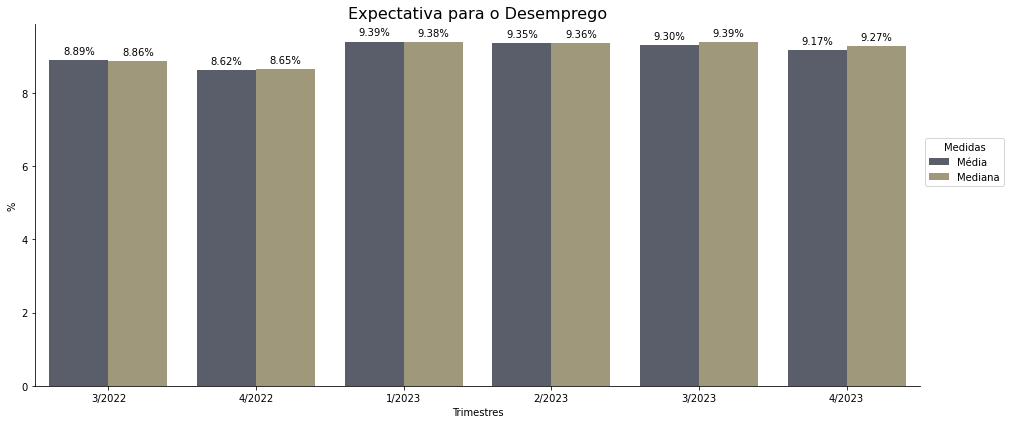

In [12]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(data = df_previsoes_desocupacao, x = 'trimestres', y = 'valor', hue = 'metrica', palette = 'cividis')
ax.set_title('Expectativa para o Desemprego', fontsize = 16)
handles, labels = ax.get_legend_handles_labels()
labels = ['Média', 'Mediana']
ax.set_xlabel('Trimestres')
ax.set_ylabel('%')
ax.legend(title = 'Medidas', handles = handles, labels = labels, bbox_to_anchor = [1.1, 0.7, 0, 0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f%%', padding = 4)
    
fig.tight_layout()
plt.show();

#### Obtendo expectativas para o cambio: Dolar

In [209]:

entidade = 'ExpectativasMercadoAnuais'
df = obtendo_expectativas('Balança comercial', entidade, 10)

In [215]:
df.IndicadorDetalhe.value_counts()

Saldo          365
Exportações    362
Importações    362
Name: IndicadorDetalhe, dtype: int64

In [85]:
def unindo_gov(x):
    
    # Selecionando trimestres
    anos = ['2022', '2023']
    
    x = x[x['DataReferencia'].isin(anos)]
    
    # Calculando as metricas
    dicio_metricas = {}
    df_aux = x.copy()
    for ano in anos:
        dicio_metricas['media_{}'.format(ano)] = df_aux['Media'].mean()
        dicio_metricas['mediana_{}'.format(ano)] = df_aux['Mediana'].mean()
        dicio_metricas['maximo_{}'.format(ano)] = df_aux['Maximo'].mean()
        dicio_metricas['minimo_{}'.format(ano)] = df_aux['Minimo'].mean()
    
    # Colocando em um dataframe
    df = pd.DataFrame(list(dicio_metricas.items()))
    df.columns = ['metrica_ano', 'valor']
    df[['metrica', 'anos']] = df['metrica_ano'].str.split('_', n = 1, expand = True)
    df = df.drop(columns = 'metrica_ano')
    df = df[['anos', 'metrica', 'valor']]
    
    df['metrica'] = np.where(df['metrica'] == 'maximo', 'Máximo',
                              np.where(df['metrica'] == 'media', 'Média',
                                       np.where(df['metrica'] == 'minimo', 'Mínimo', 'Mediana')))
    
    return df

In [86]:
unindo_bc(df, 'Saldo')

NameError: name 'unindo_bc' is not defined

In [9]:
previsao_cambio = obtendo_expectativas('Câmbio')
df_previsoes_cambio = unindo_prev(previsao_cambio)

C:\Users\thari\AppData\Local\Temp\ipykernel_1204\3837323876.py:21: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['metrica', 'trimestres']] = df['metrica_trimestre'].str.split('_', 1, expand = True)


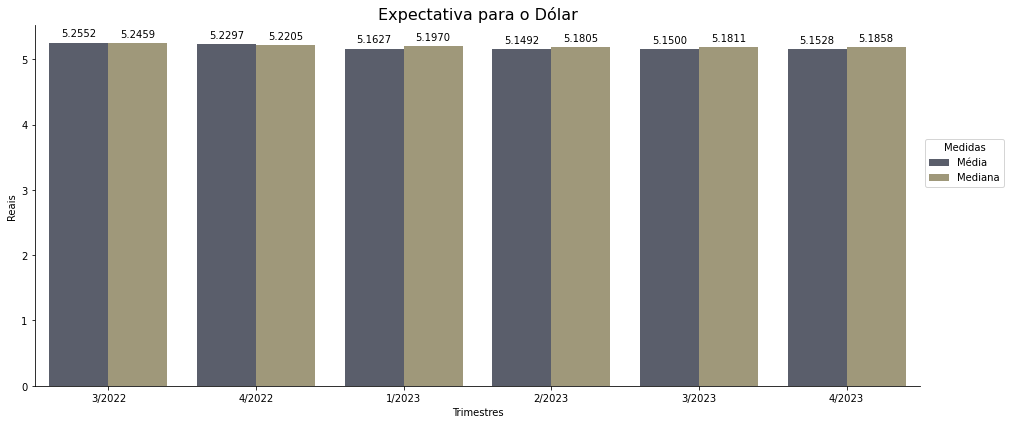

In [10]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(data = df_previsoes_cambio, x = 'trimestres', y = 'valor', hue = 'metrica', palette = 'cividis')
ax.set_title('Expectativa para o Dólar', fontsize = 16)
handles, labels = ax.get_legend_handles_labels()
labels = ['Média', 'Mediana']
ax.set_xlabel('Trimestres')
ax.set_ylabel('Reais')
ax.legend(title = 'Medidas', handles = handles, labels = labels, bbox_to_anchor = [1.1, 0.7, 0, 0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, fmt = '%.4f', padding = 4)
    
fig.tight_layout()
plt.show();

### Expectativas Governo

In [35]:
expec = Expectativas()

In [94]:
entidade = 'ExpectativasMercadoAnuais'
df = obtendo_expectativas('Investimento direto no país', entidade, 10)

In [95]:
df.head(4)

,Indicador,IndicadorDetalhe,Data,DataReferencia,Media,Mediana,Minimo,Maximo
0,Investimento direto no país,None,2022-08-15,2022,61.8532,58.00,45.0,88.0
1,Investimento direto no país,None,2022-08-15,2023,66.2800,64.50,50.0,90.0
2,Investimento direto no país,None,2022-08-15,2024,70.6642,70.00,50.0,90.0
3,Investimento direto no país,None,2022-08-15,2025,74.5426,73.41,55.0,98.0


In [96]:
df[df['DataReferencia'] == '2023']['Media'].mean()

69.61625108695652

In [97]:
df[df['DataReferencia'] == '2022']['Media'].mean()

66.39609019607842

In [98]:
def unindo_gov(x):
    
    # Selecionando trimestres
    anos = ['2022', '2023']
    
    x = x[x['DataReferencia'].isin(anos)]
    
    # Calculando as metricas
    dicio_metricas = {}
    df_aux = x.copy()
    for ano in anos:
        df_aux = x[(x['DataReferencia'] == ano)]
        dicio_metricas['media_{}'.format(ano)] = df_aux['Media'].mean()
        dicio_metricas['mediana_{}'.format(ano)] = df_aux['Mediana'].mean()
        dicio_metricas['maximo_{}'.format(ano)] = df_aux['Maximo'].mean()
        dicio_metricas['minimo_{}'.format(ano)] = df_aux['Minimo'].mean()
    
    # Colocando em um dataframe
    df = pd.DataFrame(list(dicio_metricas.items()))
    df.columns = ['metrica_ano', 'valor']
    df[['metrica', 'anos']] = df['metrica_ano'].str.split('_', n = 1, expand = True)
    df = df.drop(columns = 'metrica_ano')
    df = df[['anos', 'metrica', 'valor']]
    
    df['metrica'] = np.where(df['metrica'] == 'maximo', 'Máximo',
                              np.where(df['metrica'] == 'media', 'Média',
                                       np.where(df['metrica'] == 'minimo', 'Mínimo', 'Mediana')))
    
    return df

In [99]:
a = unindo_gov(df)

In [100]:
a

,anos,metrica,valor
0,2022,Média,66.396090
1,2022,Mediana,63.826446
2,2022,Máximo,88.104975
3,2022,Mínimo,51.868627
4,2023,Média,69.616251
5,2023,Mediana,67.563586
6,2023,Máximo,92.108989
7,2023,Mínimo,51.476428


In [9]:
df.Indicador.value_counts()

Balança comercial                                  1074
Dívida bruta do governo geral                       775
Resultado primário                                  739
Resultado nominal                                   590
Dívida líquida do setor público                     587
Câmbio                                              570
IGP-M                                               570
IPCA                                                570
PIB Total                                           570
Selic                                               570
Taxa de desocupação                                 554
IPCA Livres                                         549
IPCA Administrados                                  548
IPCA Alimentação no domicílio                       519
IPCA Bens industrializados                          510
IPCA Serviços                                       510
PIB Serviços                                        429
PIB Indústria                                   